In [ ]:
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision.models import vgg16
from sklearn.manifold import TSNE
from PIL import Image
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Experiment configuration
data_augmentation = True
batch_size_var = 512
batch_norm_var = True
l2 = True
scheduler_bool = True
early_stop = True


# number of steps for early stopping
early_stop_thresh = 3
# number of epochs
num_epochs = 100

In [ ]:
device

device(type='cuda')

# Data Normalization

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Data Loading

In [ ]:
trainset = datasets.CIFAR10(root='~/.pytorch/CIFAR10', train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root='~/.pytorch/CIFAR10', train=False, transform=transform)

train_loader = DataLoader(trainset, batch_size=batch_size_var, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size_var, shuffle=False)


Files already downloaded and verified


# Data augmentation transformation

In [ ]:
augmentation_transform = transforms.Compose([
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create a new dataset with augmented images

In [ ]:
augmented_dataset = datasets.CIFAR10(root='~/.pytorch/CIFAR10', train=True, download=True, transform=augmentation_transform)

# Concatenate the original trainset with the augmented dataset
combined_trainset = ConcatDataset([trainset, augmented_dataset])

# Create DataLoader for the combined training set only if we want it
if data_augmentation:
    train_loader = DataLoader(combined_trainset, batch_size=batch_size_var, shuffle=True)
    print("Using data augmentation")
else:
    print("No data augmentation")

Files already downloaded and verified
Using data augmentation


In [ ]:
for images, labels in train_loader:
    print(images.size(), labels.size())
    break

torch.Size([512, 3, 32, 32]) torch.Size([512])


In [ ]:
# Compare sizes of the original trainset and the augmented combined trainset
original_trainset_size = len(trainset)
augmented_trainset_size = len(augmented_dataset)
combined_trainset_size = len(combined_trainset)

print(f"Original Trainset Size: {original_trainset_size}")
print(f"Augmented Trainset Size: {augmented_trainset_size}")
print(f"Combined Trainset Size: {combined_trainset_size}")

Original Trainset Size: 50000
Augmented Trainset Size: 50000
Combined Trainset Size: 100000


In [ ]:
# Get a batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Transformation for visualization (undo normalization)
inv_normalize = transforms.Normalize(
    mean=[-mean[0] / std[0], -mean[1] / std[1], -mean[2] / std[2]],
    std=[1 / std[0], 1 / std[1], 1 / std[2]]
)


# Setting up functions

In [ ]:
# Function to display an image
def show_image(img, title):
    img = inv_normalize(img)
    img = torch.clamp(img, 0, 1)  # Clip values to stay within the valid range
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.axis('off')
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

# Function to dynamically determine the grid size with a preference for a square grid
def calculate_grid_size(filters_shape):
    num_filters = filters_shape[0]

    # Try to get a square or nearly square grid
    rows = int(num_filters ** 0.5)
    while rows > 1:
        cols = (num_filters + rows - 1) // rows
        if rows * cols >= num_filters:
            break
        rows -= 1

    return rows, cols


# Function to visualize filters and save the plots
def visualize_filters(model, layer_idx, model_name):
    layer = list(model.children())[layer_idx]

    # Check if the layer has weights
    if hasattr(layer, 'weight'):
        filters = layer.weight.data.cpu().numpy()
        #ipdb.set_trace()
        rows, cols = calculate_grid_size(filters.shape)
        #ipdb.set_trace()

        plt.figure(figsize=(cols * 2, rows * 2))
        for i in range(filters.shape[0]):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(filters[i, 0], cmap='gray')
            plt.axis('off')

        plt.savefig(f'{model_name}_layer_{layer_idx}_filters.png')
        plt.close()

# Function to visualize activations and save the plots
def visualize_activations(model, input_image, model_name):
    # Put the model in evaluation mode
    model.eval()

    # Iterate through all layers and visualize activations
    for name, module in model.named_modules():
        # Skip non-convolutional layers
        if not isinstance(module, torch.nn.Conv2d):
            continue

        # Register a forward hook to capture the activations
        activations = []

        def hook(module, input, output):
            activations.append(output)

        handle = module.register_forward_hook(hook)

        # Forward pass to capture the activations
        with torch.no_grad():
            model(input_image)

        # Unregister the hook
        handle.remove()

        # Check if the activations tensor is 4D
        if len(activations[0].shape) == 4:
            layer_name = name.replace('.', '_')  # Replace '.' in layer names for filename compatibility
            activations_tensor = activations[0].squeeze(0).cpu().numpy()
            rows, cols = calculate_grid_size(activations_tensor.shape)

            plt.figure(figsize=(cols * 2, rows * 2))
            for i in range(activations_tensor.shape[0]):
                plt.subplot(rows, cols, i + 1)
                plt.imshow(activations_tensor[i, 0], cmap='plasma')  # You can choose a colormap that suits your visualization
                plt.axis('off')

            save_path = f'{model_name}_{layer_name}_activations.png'
            plt.savefig(save_path)
            plt.close()

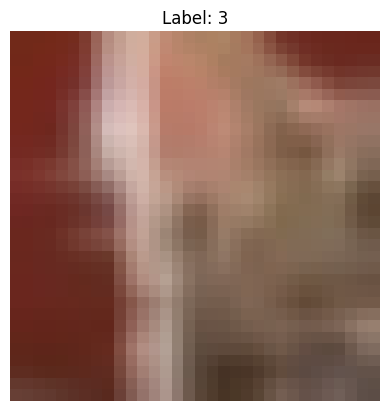

In [ ]:
# Display the first image from the batch
show_image(images[0], title=f"Label: {labels[0]}")

# Model design

In [ ]:
class CustomCNNCifar(nn.Module):
    def __init__(self, num_classes=10, batch_norm=True):
        super(CustomCNNCifar, self).__init__()
        self.batch_norm = batch_norm

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        # 16x16x8
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(8)
        self.relu1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        # 8x8x16
        if self.batch_norm:
            self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        # 4x4x32
        if self.batch_norm:
            self.bn3 = nn.BatchNorm2d(32)
        self.relu3 = nn.LeakyReLU()

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, padding_mode='zeros')
        # 2x2x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 1x1x64
        if self.batch_norm:
            self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.LeakyReLU()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64, num_classes)

        self.log_softmax = nn.LogSoftmax(dim=1)  # Softmax activation for classification

    def forward(self, x):
        x = self.conv1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.relu2(x)

        x = self.conv3(x)
        if self.batch_norm:
            x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        if self.batch_norm:
            x = self.bn4(x)
        x = self.pool1(x)
        x = self.relu4(x)

        x = self.flatten(x)

        x = self.fc1(x)

        x = self.log_softmax(x)  # Apply softmax for classification
        return x

# VGG16

## Load pre-trained VGG16 model


In [ ]:
# Load pre-trained VGG16 model
vgg16 = vgg16(pretrained=True)

In [ ]:
# Count the number of layers in the 'features' module
num_layers = sum(1 for _ in vgg16.features.children())

print(f"Total number of layers in VGG16: {num_layers}")

Total number of layers in VGG16: 31


### Filters

In [ ]:
# Visualize filters for each layer in the 'features' module
for idx in range(len(list(vgg16.features.children()))):
    visualize_filters(vgg16.features, idx, "vgg16")

### Activations

In [ ]:
# Visualize activations of VGG16 for a sample image
sample_image, _ = next(iter(test_loader))
sample_image.shape

torch.Size([512, 3, 32, 32])

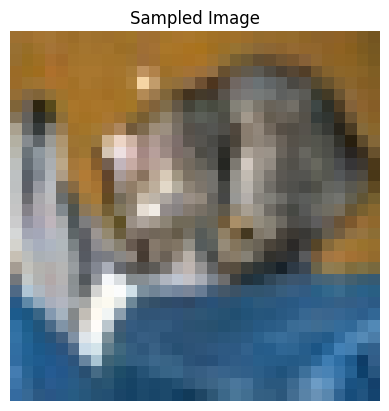

In [ ]:
show_image(sample_image[0], title=f"Sampled Image")

In [ ]:
# Visualize activations for all eligible layers and save the plots
visualize_activations(vgg16, sample_image, "vgg16")

## SimpleCNNReduced

## Load the best model of SimpleCNNReduced from Task 2

In [ ]:
# Load the saved model
loaded_model = CustomCNNCifar(num_classes=10, batch_norm=batch_norm_var)
loaded_model.load_state_dict(torch.load("best_model.pkl"))
loaded_model = loaded_model.to(device)
loaded_model.eval()

CustomCNNCifar(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): LeakyReLU(negative_slope=0.01)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_featu